In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
model = tf.keras.models.load_model('drive/MyDrive/NuclearSegmentation/model.h5')

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def load_data(path, split=0.15):
    images = sorted(glob(os.path.join(path, "TissueImages", "*")))
    masks = sorted(glob(os.path.join(path, "GroundTruth", "*")))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [5]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)

In [6]:
dataset_path = 'drive/MyDrive/NuclearSegmentation/MonuSegFull/'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
train_x, train_y = shuffle(train_x, train_y)

In [7]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 32 - 32
Valid: 6 - 6
Test: 6 - 6


In [8]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [9]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [10]:
H = 256
W = 256

batch_size = 5
lr = 3e-4
num_epochs = 30

model_path = "drive/MyDrive/NuclearSegmentation/model.h5"
csv_path = "drive/MyDrive/NuclearSegmentation/data.csv"

In [11]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [12]:
train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1

In [13]:
test_dataset = tf_dataset(test_x, test_y, batch=14)

In [14]:
for x,y in test_dataset:
    break

In [15]:
pred = model.predict(x)

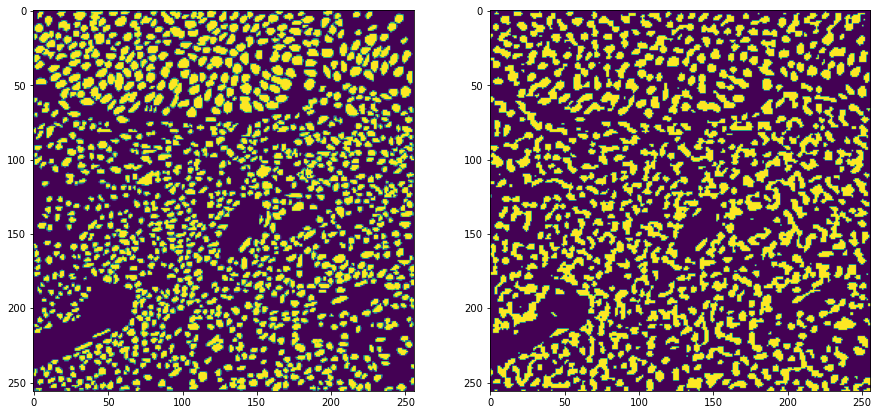

In [28]:
eim_id = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(y[eim_id, ..., 0])
axes[1].imshow(pred[eim_id, ..., 0] > 0.4)

plt.show()

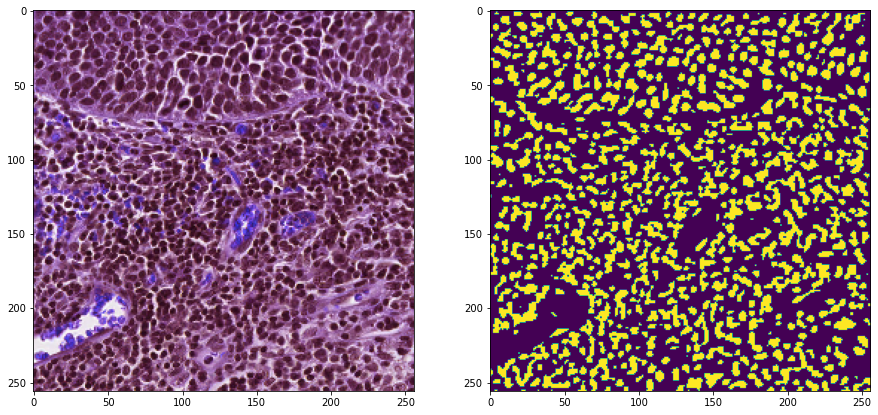

In [27]:
eim_id = 3

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[eim_id])
axes[1].imshow(pred[eim_id, ..., 0] > 0.4)

plt.show()

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [19]:
for train_x_sc, train_y_sc in train_dataset:
    break

pred_train = model.predict(train_x_sc)

for valid_x_sc, valid_y_sc in valid_dataset:
    break

pred_train = model.predict(train_x_sc)
pred_valid = model.predict(valid_x_sc)

In [20]:
import statistics

test_acc = list(map(lambda x,y: dice_coef(x, y).numpy(), tf.round(y), tf.cast(pred > 0.4, tf.float32)))
print(f'Test dataset score - {statistics.mean(test_acc) * 100}%')

train_acc = list(map(lambda x,y: dice_coef(x, y).numpy(), tf.round(train_y_sc), tf.cast(pred_train > 0.4, tf.float32)))
print(f'Train dataset score - {statistics.mean(train_acc) * 100}%')

val_acc = list(map(lambda x,y: dice_coef(x, y).numpy(), tf.round(valid_y_sc), tf.cast(pred_valid > 0.4, tf.float32)))
print(f'Validation dataset score - {statistics.mean(val_acc) * 100}%')

Test dataset score - 72.62858152389526%
Train dataset score - 69.82720494270325%
Validation dataset score - 70.80317735671997%
